# <font color='Salmon'>GPU</font>

In [1]:
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print("Tensorflow version: ", tf.version.VERSION)

2023-09-11 15:57:57.758504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 15:58:08.731238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow version:  2.13.0


In [2]:
# GPU Memory
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict Tensorflow to only use the first GPU
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs 1 Logical GPU


2023-09-11 15:58:19.182781: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7941 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:1a:00.0, compute capability: 8.6


# <font color='Salmon'>DEFINE VARIABLES</font>

In [3]:
# Model
NAME = "Model19"
PRETRAINED_MODEL = "NASNetLarge"
START_FREEZE = 0
END_FREEZE = 230 #275 #225 #701 #774 #598 #287
DENSE1 = 32
DENSE2 = 16
WEIGHT = "Model19_Mixed/32+16/ADAGRAD/Backup/Model19.E160.hdf5"#None
INITIAL_LEARNING_RATE = 1e-4
OPTIMIZER = "LION"
THRESHOLD = 0.5
THRESHOLDS = [0.8, 0.85, 0.9]

# Image processing
BATCH_SIZE = 16
SIZE = 240
SOURCE_DIR = 'Mixed'
# VILIDATION_DIR = 'Mixed_new'
VALIDATION_SPLIT = 0.25
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 180
BRIGHTNESS_RANGE = None #0.5, 0.9
ZOOM_RANGE = 0.0 #0.1, 0.5
WIDTH_SHIFT_RANGE = None #0.1
HEIGHT_SHIFT_RANGE = None #0.1
SHEAR_RANGE = None #0.1
CHANNEL_SHIFT_RANGE = 0.0 #150.0
COLOR_MODE = "rgb"

# Checkpoints
MONITOR = "val_loss"
EARLY_STOPPING_MODE = 'min'
EARLY_STOPPING_PATIENCE = 500
REDUCE_LR_FACTOR = 0.9
REDUCE_LR_PATIENCE = 50
SAVE_BEST_ONLY = True
SAVE_WEIGHT_ONLY = False

# Train Model
EPOCHS = 5000

# <font color='Salmon'>MODEL CLASS</font>

In [4]:
from tensorflow.keras import layers, Model, Input
import random
from keras.initializers import he_uniform
from tensorflow.keras.metrics import Recall, Precision
import efficientnet.keras as efn
from tensorflow.keras import backend as K

class MyModel():
    """
    Create model from pretrained model: 
        1. InceptionResNetV2, 
        2. VGG19, 
        3. VGG16, 
        4. EfficientNetB1,
        5. InceptionV3 and 
        6. Xception.
        7. EfficientNetV2B1
        8. NASNetLarge
    """
    
    def __init__(self, name):
        self.name = name

    # Base Model    
    def base_model(self, size, color_mode, pretrained_model, start_freeze, end_freeze):
        # Check for erroneous input
        if not (isinstance(start_freeze, (int, float)) \
                or isinstance(end_freeze, (int, float)) \
                or isinstance(size, (int, float)) \
               ):
            raise TypeError('Inputs must be numbers.')
        
        if color_mode == "rgb":
            depth = 3
            pretrained_weights = 'imagenet'
        elif color_mode == "grayscale":
            depth = 1
            pretrained_weights = None
        
        if pretrained_model == "InceptionResNetV2":
            my_base_model = tf.keras.applications.InceptionResNetV2(
                include_top=False,
                weights=pretrained_weights,
                input_shape=(size, size, depth),
            )
            
        elif pretrained_model == "Xception":
            my_base_model = tf.keras.applications.Xception(
                include_top=False,
                weights=pretrained_weights,
                input_shape=(size, size, depth),
            )
            
        elif pretrained_model == "VGG19":
            my_base_model = tf.keras.applications.VGG19(
                include_top=False,
                weights=pretrained_weights,
                input_shape=(size, size, depth),
            )
        
        elif pretrained_model == "VGG16":
            my_base_model = tf.keras.applications.VGG16(
                include_top=False,
                weights=pretrained_weights,
                input_shape=(size, size, depth),
            )
        
        elif pretrained_model == "InceptionV3":
            my_base_model = tf.keras.applications.InceptionV3(
                include_top=False,
                weights=pretrained_weights,
                input_shape=(size, size, depth),
            )
            
        elif pretrained_model == "EfficientNetB1":
            my_base_model = efn.EfficientNetB1(
                include_top=False,
                weights=pretrained_weights,
                input_shape=(size, size, depth),
            )
            
        elif pretrained_model == "EfficientNetV2B1":
            my_base_model = tf.keras.applications.EfficientNetV2B1(
                include_top=False,
                weights=pretrained_weights,
                input_shape=(size, size, depth),
            )
            
        elif pretrained_model == "NASNetLarge":
            my_base_model = tf.keras.applications.NASNetLarge(
                include_top=False,
                weights=pretrained_weights,
                input_shape=(size, size, depth),
            )
            
        for layer in my_base_model.layers[start_freeze:end_freeze]:
            layer.trainable = False
            
        return my_base_model

    # Optimizer
    def custom_optimizer(self, optimizer, lr):
        '''
        Define custom optimizer
        '''
        if optimizer == "ADAM":
            optimizer = tf.keras.optimizers.Adam(
                learning_rate=lr,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07,
                amsgrad=False,
                weight_decay=None,
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=None,
                jit_compile=True,
                name='Adam',
            )
            
        # elif optimizer == "SGD":
        #     optimizer = tf.keras.optimizers.SGD(
        #         learning_rate=lr, # default e-2
        #         momentum=0.9,
        #         nesterov=True,
        #         # amsgrad=False,
        #         # decay=1e-6,
        #         # clipnorm=None,
        #         # clipvalue=None,
        #         # global_clipnorm=None,
        #         # use_ema=False,
        #         # ema_momentum=0.99,
        #         # ema_overwrite_frequency=None,
        #         # jit_compile=True,
        #         name="SGD",
        #     )

        # elif optimizer == "RMSPROP":
        #     optimizer = tf.keras.optimizers.RMSprop(
        #         learning_rate=lr,
        #         rho=0.9,
        #         momentum=0.9,
        #         epsilon=1e-07,
        #         centered=False,
        #         decay=1e-6,
        #         # clipnorm=None,
        #         # clipvalue=None,
        #         # global_clipnorm=None,
        #         # use_ema=False,
        #         # ema_momentum=0.99,
        #         # ema_overwrite_frequency=100,
        #         # jit_compile=True,
        #         name="RMSprop",
        #     )

        elif optimizer == "ADAMW":
            optimizer = tf.keras.optimizers.AdamW(
                learning_rate=lr,
                weight_decay=0.004,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07,
                amsgrad=False,
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=None,
                jit_compile=True,
                name='AdamW',
            )

        elif optimizer == "ADAFACTOR":
            optimizer = tf.keras.optimizers.Adafactor(
                learning_rate=lr,
                beta_2_decay=-0.8,
                epsilon_1=1e-30,
                epsilon_2=0.001,
                clip_threshold=1.0,
                relative_step=True,
                weight_decay=None,
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=None,
                jit_compile=True,
                name='Adafactor',
            )

        elif optimizer == "LION":
            optimizer = tf.keras.optimizers.Lion(
                learning_rate=lr, #0.0001
                beta_1=0.9,
                beta_2=0.99,
                weight_decay=None,
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=None,
                jit_compile=True,
                name='Lion',
            )

        elif optimizer == "ADADELTA":
            optimizer = tf.keras.optimizers.experimental.Adadelta(
                learning_rate=lr,
                rho=0.95,
                epsilon=1e-07,
                weight_decay=None,
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=None,
                jit_compile=True,
                name='Adadelta',
            )

        elif optimizer == "NADAM":
            optimizer = tf.keras.optimizers.experimental.Nadam(
                learning_rate=lr,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07,
                weight_decay=None,
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=None,
                jit_compile=True,
                name='Nadam',
            )

        elif optimizer == "ADAMAX":
            optimizer = tf.keras.optimizers.experimental.Adamax(
                learning_rate=lr,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07,
                weight_decay=None,
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=None,
                jit_compile=True,
                name='Adamax',
            )
         
        elif optimizer == "ADAGRAD":
            optimizer = tf.keras.optimizers.experimental.Adagrad(
                learning_rate=lr,
                initial_accumulator_value=0.1,
                epsilon=1e-07,
                weight_decay=None,
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=None,
                jit_compile=True,
                name='Adagrad',
            )

        elif optimizer == "FTRL":
            optimizer = tf.keras.optimizers.experimental.Ftrl(
                learning_rate=lr,
                learning_rate_power=-0.5,
                initial_accumulator_value=0.1,
                l1_regularization_strength=0.0,
                l2_regularization_strength=0.0,
                l2_shrinkage_regularization_strength=0.0,
                beta=0.0,
                weight_decay=None,
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=None,
                jit_compile=True,
                name='Ftrl',
            )

        elif optimizer == "RMSPROP":
            optimizer = tf.keras.optimizers.experimental.RMSprop(
                learning_rate=lr,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False,
                weight_decay=None,
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=100,
                jit_compile=True,
                name='RMSprop',
            )

        elif optimizer == "SGD":
            optimizer = tf.keras.optimizers.experimental.SGD(
                learning_rate=lr, #0.01
                momentum=0.0,
                nesterov=False,
                weight_decay=None,
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=None,
                jit_compile=True,
                name='SGD',
            )
         
        return optimizer


    # Custom Metrics
    def custom_metrics(self):
        '''
        Define custom metrics
        '''
        custom_metrics = [
            'acc', 
            'mean_squared_error',
            tf.keras.metrics.TruePositives(
                name='tp',
                thresholds=THRESHOLD,
            ),
            tf.keras.metrics.TrueNegatives(
                name='tn',
                thresholds=THRESHOLD,
            ),
            tf.keras.metrics.FalseNegatives(
                name='fn',
                thresholds=THRESHOLD,
            ),
            tf.keras.metrics.FalsePositives( 
                name='FP',
                thresholds=THRESHOLD,
            ),                
            tf.keras.metrics.Precision(
                name='precision',
                thresholds=THRESHOLD,
            ),
            tf.keras.metrics.Recall(
                name='recall',
                thresholds=THRESHOLD,
            ),
            tf.keras.metrics.AUC(
                num_thresholds=200,
                curve='ROC',
                summation_method='interpolation',
                name='auc',
                dtype=None,
                thresholds=None,
                multi_label=False,
                num_labels=None,
                label_weights=None,
                from_logits=False
            ),
            tf.keras.metrics.AUC(
                name='prc', 
                curve='PR',
                # thresholds=THRESHOLDS,
            ), # precision-recall curve
            tf.keras.metrics.BinaryAccuracy(
                name="binary_accuracy",  
                threshold=THRESHOLD,
            ),
            tf.keras.metrics.FBetaScore(
                average="weighted",
                beta=0.5,
                threshold=THRESHOLD,
                name='fbeta_score',
                dtype=None
            ),
            ]
        
        return custom_metrics
    
    # Create Model
    def create_model(self, base_model, dense1, dense2, weight):
        '''
        Create model
        '''
        # Check for erroneous input
        if not (isinstance(dense1, (int, float)) \
                or isinstance(dense2, (int, float)) \
                or isinstance(dropout_rate, (int, float))
               ):
            raise TypeError('Inputs must be numbers.')
        
        # Variables
        seed = random.randint(1, 1000)
        leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2) # defaults to alpha=0.3        
        
        # inputs
        input_model = base_model
        x = input_model.output

        # top layer
        x = layers.GlobalAveragePooling2D()(x)
         
        if dense1 and dense1 > 0:
            x = layers.BatchNormalization()(x)
            x = layers.Activation("swish")(x) #swish
            x = layers.Dense(dense1,
                             kernel_initializer=he_uniform(seed),
                             use_bias=False)(x)
            
        if dense2 and dense2 > 0:
            x = layers.BatchNormalization()(x)
            x = layers.Activation("swish")(x)
            x = layers.Dense(dense2,
                             kernel_initializer=he_uniform(seed),
                             use_bias=False)(x)
            
        x = layers.BatchNormalization()(x)
        x = layers.Activation("swish")(x)

        # Outputs
        outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

        # Uncompiled Model
        created_model = tf.keras.Model(inputs=input_model.input, 
                                       outputs=outputs, 
                                       name=self.name)

        # Load weights
        if weight is not None:
            created_model.load_weights(weight)
            
        return created_model
        
    # Compile Model
    def compile_model(self, uncompiled_model, optimizer, lr):
        '''
        Compile model
        '''
        uncompiled_model.compile(
            optimizer=self.custom_optimizer(optimizer, lr),
            loss='binary_crossentropy',
            metrics=self.custom_metrics(),
        )
        
        compiled_model = uncompiled_model

        # Display trainable layers
        for i, layer in enumerate(compiled_model.layers):
            print(i, layer.name, "- trainable =", layer.trainable)

        return compiled_model

# <font color='Salmon'>DEFINE MODEL</font>

In [5]:
mymodel = MyModel(
    name = NAME,
)

my_base_model = mymodel.base_model(
    size = SIZE,
    color_mode = COLOR_MODE,
    pretrained_model = PRETRAINED_MODEL,
    start_freeze = START_FREEZE,
    end_freeze = END_FREEZE,
)

my_created_model = mymodel.create_model(
    base_model = my_base_model,
    dense1 = DENSE1,
    dense2 = DENSE2,
    weight = WEIGHT,
)

model = mymodel.compile_model(
    uncompiled_model=my_created_model, 
    optimizer=OPTIMIZER, 
    lr=INITIAL_LEARNING_RATE
)

0 input_1 - trainable = False
1 stem_conv1 - trainable = False
2 stem_bn1 - trainable = False
3 activation - trainable = False
4 reduction_conv_1_stem_1 - trainable = False
5 reduction_bn_1_stem_1 - trainable = False
6 activation_1 - trainable = False
7 activation_3 - trainable = False
8 separable_conv_1_pad_reduction_left1_stem_1 - trainable = False
9 separable_conv_1_pad_reduction_right1_stem_1 - trainable = False
10 separable_conv_1_reduction_left1_stem_1 - trainable = False
11 separable_conv_1_reduction_right1_stem_1 - trainable = False
12 separable_conv_1_bn_reduction_left1_stem_1 - trainable = False
13 separable_conv_1_bn_reduction_right1_stem_1 - trainable = False
14 activation_2 - trainable = False
15 activation_4 - trainable = False
16 separable_conv_2_reduction_left1_stem_1 - trainable = False
17 separable_conv_2_reduction_right1_stem_1 - trainable = False
18 activation_5 - trainable = False
19 separable_conv_2_bn_reduction_left1_stem_1 - trainable = False
20 separable_conv_2

# <font color='Salmon'>PREPROCESS DATASET</font>

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np

# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
train_image_gen = ImageDataGenerator(
    # preprocessing_function=preprocess_input,
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    horizontal_flip=HORIZONTAL_FLIP,
    vertical_flip=VERTICAL_FLIP,
    rotation_range=ROTATION_RANGE,
    brightness_range=BRIGHTNESS_RANGE,
    zoom_range=ZOOM_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    shear_range=SHEAR_RANGE,
    channel_shift_range=CHANNEL_SHIFT_RANGE,
    # fill_mode='nearest',
    # cval=0.0,
    # data_format='channels_last',
    # interpolation_order=1,
    # dtype=None
    # featurewise_center=True,
    # samplewise_center=True,
    # featurewise_std_normalization=True,
    # samplewise_std_normalization=True,
    # zca_whitening=False,
    # zca_epsilon=1e-06,
)

train_generator = train_image_gen.flow_from_directory(
    SOURCE_DIR,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    target_size=(SIZE, SIZE),
    shuffle=True,
    # seed=42,
    save_format='bmp',
    # classes=None,
    # save_to_dir=SAVE_TO_DIR,
    # save_prefix='',
    # follow_links=False,
    # subset='training',
    # interpolation='nearest',
    # keep_aspect_ratio=False,
    color_mode=COLOR_MODE,
)

val_image_gen = ImageDataGenerator(
    # preprocessing_function=preprocess_input,
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
)

validation_generator = train_image_gen.flow_from_directory(
    SOURCE_DIR,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    target_size=(SIZE, SIZE),
    shuffle=True,
    # seed=42,
    subset='validation',
    color_mode=COLOR_MODE,                                                             
)

# Define Class Weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

CLASS_WEIGHT = dict([(0, class_weights[1]), (1, class_weights[0])])
print("Class Weight =", CLASS_WEIGHT)

Found 887 images belonging to 2 classes.
Found 221 images belonging to 2 classes.
Class Weight = {0: 0.7428810720268006, 1: 1.5293103448275862}


# <font color='Salmon'>CALLBACKS AND CHECKPOINTS</font>

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import LearningRateScheduler
from livelossplot import PlotLossesKeras
import os


CHECKPOINT_DIR = NAME + "_" + SOURCE_DIR
CHECKPOINT_FORMAT = str(NAME) + "." \
                    "E{epoch:03d}."\
                    "hdf5"
DENSE = str(DENSE1) + "+" + str(DENSE2)
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, DENSE, OPTIMIZER, CHECKPOINT_FORMAT)

# Make Directories
try:
    os.makedirs(CHECKPOINT_DIR, exist_ok = True)
    print("Directory '%s' created successfully" %CHECKPOINT_DIR)
except OSError as error:
    print("Directory '%s' can not be created")


# Callback LiveLossPlot
plotlosses = PlotLossesKeras()

# CSV logger
csv_log = CSVLogger("results.csv")

# Early Stopping
early_stopping = EarlyStopping(
    monitor= MONITOR, 
    mode = EARLY_STOPPING_MODE,
    verbose = 1,
    patience = EARLY_STOPPING_PATIENCE,
    min_delta=0,
    baseline=0.01,
    restore_best_weights=True,
)

## Reduce learning rate if it gets stuck in a plateau
reduced_lr = ReduceLROnPlateau(
    monitor = MONITOR,
    factor = REDUCE_LR_FACTOR, 
    patience = REDUCE_LR_PATIENCE,
    min_lr = 0,
    mode = 'auto',
    min_delta = 0.0001,
    cooldown = 0,
    verbose = 1,
)

# ModelCheckpoint callback - Precision
checkpoint_precision = ModelCheckpoint(
    # CHECKPOINT_PRECISION_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = 'precision', 
    mode = 'max',
    verbose = 1,
)

# ModelCheckpoint callback - Val Precision
checkpoint_val_precision = ModelCheckpoint(
    # CHECKPOINT_VAL_PRECISION_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = 'val_precision', 
    mode = 'max',
    verbose = 1,
)

# ModelCheckpoint callback - Recall
checkpoint_recall = ModelCheckpoint(
    # CHECKPOINT_RECALL_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = 'recall', 
    mode = 'max',
    verbose = 1,
)

# ModelCheckpoint callback - Val Recall
checkpoint_val_recall = ModelCheckpoint(
    # CHECKPOINT_VAL_RECALL_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = 'val_recall', 
    mode = 'max',
    verbose = 1,
)

# ModelCheckpoint callback - AUC
checkpoint_auc = ModelCheckpoint(
    # CHECKPOINT_AUC_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = 'auc', 
    mode = 'max',
    verbose = 1,
)

# ModelCheckpoint callback - VAL AUC
checkpoint_val_auc = ModelCheckpoint(
    # CHECKPOINT_VAL_AUC_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = 'val_auc', 
    mode = 'max',
    verbose = 1,
)

# ModelCheckpoint callback - prc
checkpoint_prc = ModelCheckpoint(
    # CHECKPOINT_PRC_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = 'prc', 
    mode = 'max',
    verbose = 1,
)

# ModelCheckpoint callback - val prc
checkpoint_val_prc = ModelCheckpoint(
    # CHECKPOINT_VAL_PRC_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = 'val_prc', 
    mode = 'max',
    verbose = 1,
)

# ModelCheckpoint callback - Validation Loss
checkpoint_val_loss = ModelCheckpoint(
    # CHECKPOINT_LOSS_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = 'val_loss', 
    mode = 'min',
    verbose = 1,
)

# ModelCheckpoint callback - Loss
checkpoint_loss = ModelCheckpoint(
    # CHECKPOINT_VAL_LOSS_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = 'loss', 
    mode = 'min',
    verbose = 1,
)

# ModelCheckpoint callback - Accuracy
checkpoint_acc = ModelCheckpoint(
    # CHECKPOINT_ACC_PATH,
    CHECKPOINT_PATH,
    monitor = 'acc',
    mode = 'max',
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    verbose = 1,
)

# ModelCheckpoint callback - Validation Accuracy
checkpoint_val_acc = ModelCheckpoint(
    # CHECKPOINT_VAL_ACC_PATH,
    CHECKPOINT_PATH,
    monitor = 'val_acc',
    mode = 'max',
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    verbose = 1,
)

# ModelCheckpoint callback - False Positive
checkpoint_fp = ModelCheckpoint(
    # CHECKPOINT_FP_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = 'FP', 
    mode = 'min',
    verbose = 1,
)

# ModelCheckpoint callback - Validation False Positive
checkpoint_val_fp = ModelCheckpoint(
    # CHECKPOINT_VAL_FP_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = 'val_FP', 
    mode = 'min',
    verbose = 1,
)

# ModelCheckpoint callback - Mean Square Error
checkpoint_mse = ModelCheckpoint(
    # CHECKPOINT_MSE_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = 'mean_squared_error', 
    mode = 'min',
    verbose = 1,
)

# ModelCheckpoint callback - Validation Mean Square Error
checkpoint_val_mse = ModelCheckpoint(
    # CHECKPOINT_VAL_MSE_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = 'val_mean_squared_error', 
    mode = 'min',
    verbose = 1,
)

# ModelCheckpoint callback - Binary Accuracy
checkpoint_ba = ModelCheckpoint(
    # CHECKPOINT_BA_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = "binary_accuracy", 
    mode = 'max',
    verbose = 1,
)

# ModelCheckpoint callback - Validation Binary Accuracy
checkpoint_val_ba = ModelCheckpoint(
    # CHECKPOINT_VAL_BA_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = "val_binary_accuracy", 
    mode = 'max',
    verbose = 1,
)

# ModelCheckpoint callback - Fbeta score
checkpoint_fbeta_score = ModelCheckpoint(
    # CHECKPOINT_FBETA_SCORE_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = "fbeta_score", 
    mode = 'max',
    verbose = 1,
)

# ModelCheckpoint callback - Validation Fbeta score
checkpoint_val_fbeta_score = ModelCheckpoint(
    # CHECKPOINT_VAL_FBETA_SCORE_PATH,
    CHECKPOINT_PATH,
    save_best_only = SAVE_BEST_ONLY,
    save_weights_only = SAVE_WEIGHT_ONLY,
    monitor = "val_fbeta_score", 
    mode = 'max',
    verbose = 1,
)

Directory 'Model19_Mixed' created successfully


# <font color='Salmon'>TRAIN MODEL</font>

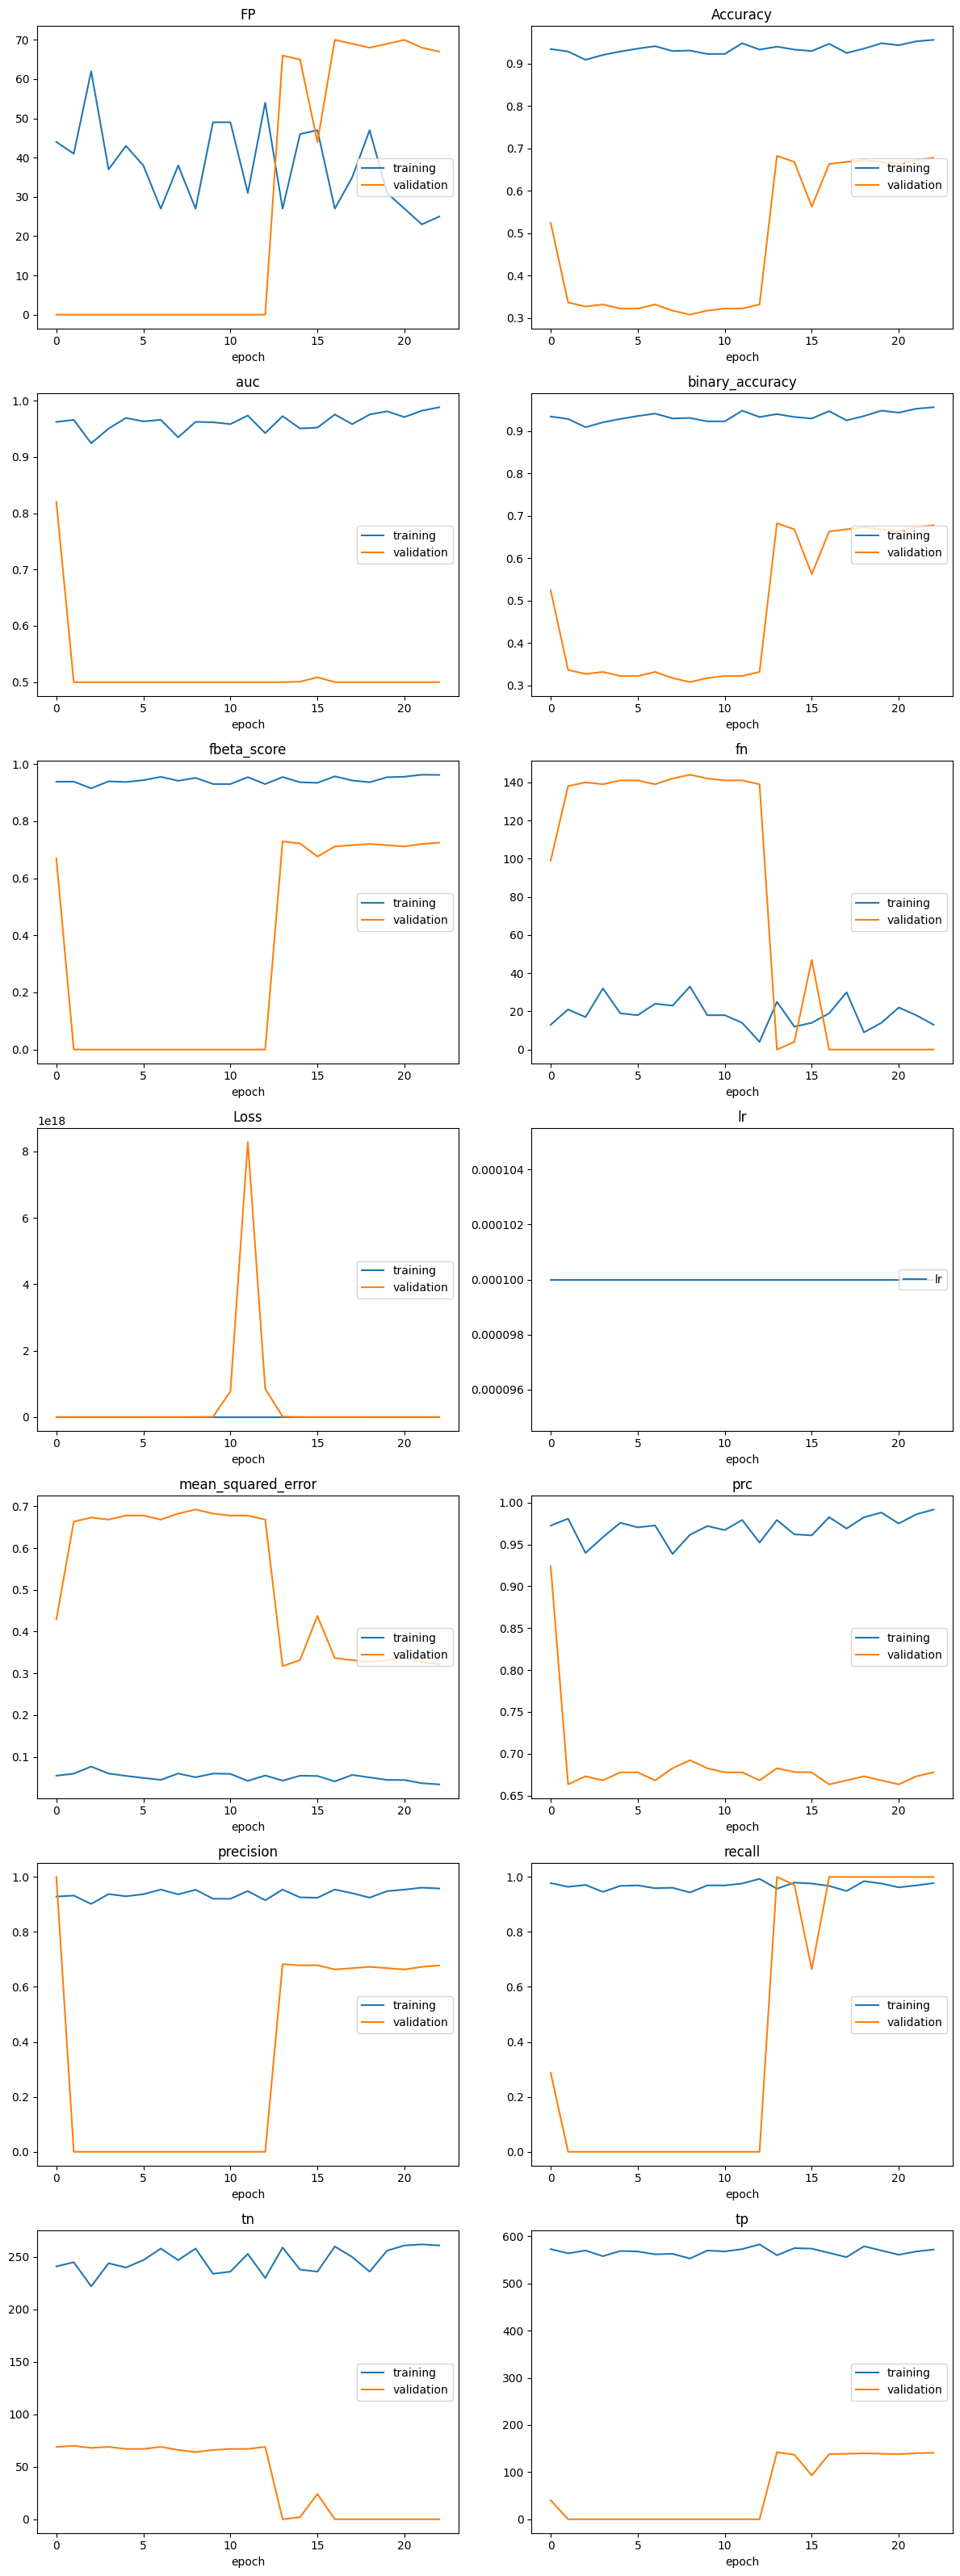

FP
	training         	 (min:   23.000, max:   62.000, cur:   25.000)
	validation       	 (min:    0.000, max:   70.000, cur:   67.000)
Accuracy
	training         	 (min:    0.909, max:    0.956, cur:    0.956)
	validation       	 (min:    0.308, max:    0.683, cur:    0.678)
auc
	training         	 (min:    0.924, max:    0.988, cur:    0.988)
	validation       	 (min:    0.500, max:    0.820, cur:    0.500)
binary_accuracy
	training         	 (min:    0.909, max:    0.956, cur:    0.956)
	validation       	 (min:    0.308, max:    0.683, cur:    0.678)
fbeta_score
	training         	 (min:    0.915, max:    0.963, cur:    0.962)
	validation       	 (min:    0.000, max:    0.729, cur:    0.725)
fn
	training         	 (min:    4.000, max:   33.000, cur:   13.000)
	validation       	 (min:    0.000, max:  144.000, cur:    0.000)
Loss
	training         	 (min:    0.122, max:    0.269, cur:    0.122)
	validation       	 (min:    3.223, max: 8281352255618154496.000, cur: 207036579840.000)
l

In [ ]:
if SAVE_BEST_ONLY == True:
    CALLBACKS = [
        checkpoint_acc,
        checkpoint_val_acc,
        checkpoint_loss,
        checkpoint_val_loss,
        checkpoint_mse,
        checkpoint_val_mse,
        checkpoint_auc,
        checkpoint_val_auc,
        checkpoint_prc,
        checkpoint_val_prc,
        checkpoint_fp,
        checkpoint_val_fp,
        checkpoint_ba,
        checkpoint_val_ba,
        checkpoint_precision,
        checkpoint_val_precision,
        checkpoint_recall,
        checkpoint_val_recall,
        checkpoint_fbeta_score,
        checkpoint_val_fbeta_score,
        early_stopping,
        reduced_lr,
        plotlosses,
        # csv_log,
        ]
else:
    CALLBACKS = [
        checkpoint_auc,
        plotlosses,
        early_stopping,
        reduced_lr,        
    ]

history = model.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    verbose=1,
    callbacks=CALLBACKS,
    class_weight=CLASS_WEIGHT,
)

# <font color='Salmon'>PLOT</font>

In [ ]:
# %matplotlib ipympl
# import matplotlib.pyplot as plt
# import pandas as pd

# plt.plot(history.history["acc"])
# plt.plot(history.history['val_acc'])
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title("model accuracy")
# plt.ylabel("Accuracy")
# plt.xlabel("Epoch")
# plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
# plt.show()

# pd.read_csv("results.csv", index_col='epoch')



# <font color='Salmon'>PREDICTION</font>

## <font color='lightsalmon'>SFA</font>

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.metrics import confusion_matrix, classification_report
# import os, sys, shutil, csv, glob, gc
# import matplotlib.pyplot as plt
# from keras.models import load_model
# from tensorflow.keras import backend as K

# SIZE = 45
# TEST_DIR = "../../../SFA_Test"
# BATCH = 1
# RED_RIVER_UNDERKILL_DIR = "../../../SFA_Underkill/"
# CSV_FILE = "../../../SFA_Underkill.csv"
# THRESHOLD = 0.9
# path = os.path.join(CHECKPOINT_DIR, DENSE, OPTIMIZER)
# TESTED_PATH = "tested/"

# os.chdir(os.path.expanduser("~/DL/MIT"))
# os.chdir(path)

# # Make Directories
# try:
#     os.makedirs(TESTED_PATH, exist_ok = True)
#     print("Directory '%s' created successfully" %TESTED_PATH)
# except OSError as error:
#     print("Directory '%s' cannot be created")

# for MODEL_FILE in sorted(filter(os.path.isfile, glob.glob("*.hdf5")), reverse=True):
#     print(MODEL_FILE)

#     trained_model = load_model(MODEL_FILE)

#     test_datagen = ImageDataGenerator(
#         rescale = 1./255,
#     )

#     test_generator = test_datagen.flow_from_directory(
#         directory = TEST_DIR,
#         target_size = (SIZE, SIZE),
#         class_mode = "binary",
#         shuffle = False,
#         batch_size = BATCH,
#         color_mode=COLOR_MODE,
#     )

#     predictions = trained_model.predict(test_generator, verbose=0)

#     # Confusion Matrix
#     classes = test_generator.classes
#     labels = 1*(predictions > THRESHOLD) # convert probability to classes
#     CM = confusion_matrix(classes, labels)
    
#     CSTART = '\x1b[6;30;43m'
#     CEND = '\x1b[0m'
#     if CM[0][1] == 0:
#         print(CSTART + "Zero Underkill" + CEND, "Overkill =", CM[1][0])
#         shutil.copyfile(MODEL_FILE, TESTED_PATH + MODEL_FILE)
#     else:
#         print("Underkill =", CM[0][1], "Overkill =", CM[1][0])

#     test_generator.reset()
#     K.clear_session()
#     _ = gc.collect()

## <font color='lightsalmon'>Single Model - SFA</font>

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.metrics import confusion_matrix
# from mlxtend.plotting import plot_confusion_matrix
# import numpy as np
# import os, sys, shutil, csv
# from sklearn.metrics import classification_report
# import matplotlib.pyplot as plt
# from keras.models import load_model

# os.chdir(os.path.expanduser("~/DL/MIT"))

# BEST_MODEL = 'Model19_SFA_Train/32+16/NADAM/Model19.E054.hdf5'

# trained_model = load_model(BEST_MODEL)

# # os.chdir(os.path.expanduser("Downloads/MIT"))

# SIZE = 45
# TEST_DIR = "SFA_Test"
# JUNO_OVERKILL_DIR = "Juno_Overkill/"
# CSV_FILE = "Juno_Underkill.csv"
# BATCH = 1
# THRESHOLD = 0.9


# test_datagen = ImageDataGenerator(
#     rescale = 1./255,
# )

# test_generator = test_datagen.flow_from_directory(
#     directory = TEST_DIR,
#     target_size = (SIZE, SIZE),
#     class_mode = "binary",
#     shuffle = False,
#     batch_size = BATCH,
#     color_mode=COLOR_MODE,
# )
    
# predictions = trained_model.predict(test_generator)

# # Display each file
# files = test_generator.filenames
# classes = test_generator.classes
# classes_names = test_generator.class_indices.keys()

# # Confusion Matrix
# labels = 1*(predictions > THRESHOLD) # convert proba to classes
# CM = confusion_matrix(classes, labels)
# fig, ax = plot_confusion_matrix(
#     conf_mat=CM, 
#     figsize=(10, 10), 
#     class_names=classes_names,
#     # colorbar=True,
#     # cmap='summer',
# )
# plt.show()
# # print(classification_report(classes, labels))

# for i, p in enumerate(predictions):
#     # Write CSV file
#     score = [i, files[i], p[0]]
#     with open(CSV_FILE,'a',newline='') as csvfile:
#         writer = csv.writer(csvfile, delimiter=',')
#         writer.writerow(score)
#     csvfile.close()
    
#     if classes[i] == 0 and p[0] > THRESHOLD:
#         print(i, files[i], p[0], "UNDERKILL")
#     elif classes[i] == 1 and p[0] < THRESHOLD:
#         print(i, files[i], p[0], "OVERKILL")
#         shutil.copyfile(os.path.join(TEST_DIR, files[i]), JUNO_OVERKILL_DIR + files[i])
#     else:
#         print(i, files[i], p[0])
        
# print("Underkill =", CM[0][1])
# print("Overkill =", CM[1][0])
# test_generator.reset()

## <font color='lightsalmon'>All Models - Red River</font>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import os, sys, shutil, csv, glob, gc
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras import backend as K

SIZE = 240
TEST_DIR = "../../../RedRiver_All"
BATCH = 1
RED_RIVER_UNDERKILL_DIR = "../../../RedRiver_Underkill/"
CSV_FILE = "../../../RedRiver_Underkill.csv"
THRESHOLD = 0.9
path = os.path.join(CHECKPOINT_DIR, DENSE, OPTIMIZER)
TESTED_PATH = "tested/"

os.chdir(os.path.expanduser("~/DL"))
os.chdir(path)

# Make Directories
try:
    os.makedirs(TESTED_PATH, exist_ok = True)
    print("Directory '%s' created successfully" %TESTED_PATH)
except OSError as error:
    print("Directory '%s' cannot be created")

for MODEL_FILE in sorted(filter(os.path.isfile, glob.glob("*.hdf5")), reverse=True):
    print(MODEL_FILE)

    trained_model = load_model(MODEL_FILE)

    test_datagen = ImageDataGenerator(
        rescale = 1./255,
    )

    test_generator = test_datagen.flow_from_directory(
        directory = TEST_DIR,
        target_size = (SIZE, SIZE),
        class_mode = "binary",
        shuffle = False,
        batch_size = BATCH,
        color_mode=COLOR_MODE,
    )

    predictions = trained_model.predict(test_generator, verbose=0)

    # Confusion Matrix
    classes = test_generator.classes
    labels = 1*(predictions > THRESHOLD) # convert probability to classes
    CM = confusion_matrix(classes, labels)
    
    CSTART = '\x1b[6;30;43m'
    CEND = '\x1b[0m'
    if CM[0][1] == 0:
        print(CSTART + "Zero Underkill" + CEND, "Overkill =", CM[1][0])
        shutil.copyfile(MODEL_FILE, TESTED_PATH + MODEL_FILE)
    else:
        print("Underkill =", CM[0][1], "Overkill =", CM[1][0])

    test_generator.reset()
    K.clear_session()
    _ = gc.collect()

## <font color='lightsalmon'>All Models - Juno</font>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import os, sys, shutil, csv, glob, gc
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras import backend as K

SIZE = 240
TEST_DIR = "../../../Juno_All"
BATCH = 1
RED_RIVER_UNDERKILL_DIR = "../../../Juno_Underkill/"
CSV_FILE = "../../../Juno_Underkill.csv"
THRESHOLD = 0.9
TESTED_PATH = "tested"
path = os.path.join(CHECKPOINT_DIR, DENSE, OPTIMIZER)

os.getcwd()
os.chdir(os.path.expanduser("~/DL"))
os.chdir(path)

for MODEL_FILE in sorted(filter(os.path.isfile, glob.glob("*.hdf5")), reverse=True):
    print(MODEL_FILE)

    trained_model = load_model(MODEL_FILE)

    test_datagen = ImageDataGenerator(
        rescale = 1./255,
    )

    test_generator = test_datagen.flow_from_directory(
        directory = TEST_DIR,
        target_size = (SIZE, SIZE),
        class_mode = "binary",
        shuffle = False,
        batch_size = BATCH,
        color_mode=COLOR_MODE,
    )

    predictions = trained_model.predict(test_generator, verbose=0)

    # Confusion Matrix
    classes = test_generator.classes
    labels = 1*(predictions > THRESHOLD) # convert probability to classes
    CM = confusion_matrix(classes, labels)
    
    CSTART = '\x1b[6;30;43m'
    CEND = '\x1b[0m'
    if CM[0][1] == 0:
        print(CSTART + "Zero Underkill" + CEND, "Overkill =", CM[1][0])
    else:
        print("Underkill =", CM[0][1], "Overkill =", CM[1][0])

    test_generator.reset()
    K.clear_session()
    _ = gc.collect()

## <font color='lightsalmon'>All Models - YenZhi</font>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import os, sys, shutil, csv, glob, gc
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras import backend as K

SIZE = 240
TEST_DIR = "../../../YenZhi"
BATCH = 1
RED_RIVER_UNDERKILL_DIR = "../../../YenZhi_Underkill/"
CSV_FILE = "../../../YenZhi_Underkill.csv"
THRESHOLD = 0.9
TESTED_PATH = "tested"
path = os.path.join(CHECKPOINT_DIR, DENSE, OPTIMIZER)

os.getcwd()
os.chdir(os.path.expanduser("~/DL"))
os.chdir(path)

for MODEL_FILE in sorted(filter(os.path.isfile, glob.glob("*.hdf5")), reverse=True):
    print(MODEL_FILE)

    trained_model = load_model(MODEL_FILE)

    test_datagen = ImageDataGenerator(
        rescale = 1./255,
    )

    test_generator = test_datagen.flow_from_directory(
        directory = TEST_DIR,
        target_size = (SIZE, SIZE),
        class_mode = "binary",
        shuffle = False,
        batch_size = BATCH,
        color_mode=COLOR_MODE,
    )

    predictions = trained_model.predict(test_generator, verbose=0)

    # Confusion Matrix
    classes = test_generator.classes
    labels = 1*(predictions > THRESHOLD) # convert probability to classes
    CM = confusion_matrix(classes, labels)
    
    CSTART = '\x1b[6;30;43m'
    CEND = '\x1b[0m'
    if CM[0][1] == 0:
        print(CSTART + "Zero Underkill" + CEND, "Overkill =", CM[1][0])
    else:
        print("Underkill =", CM[0][1], "Overkill =", CM[1][0])

    test_generator.reset()
    K.clear_session()
    _ = gc.collect()

## <font color='lightsalmon'>All Models - EOS - tested</font>

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.metrics import confusion_matrix, classification_report
# import os, sys, shutil, csv, glob, gc
# import matplotlib.pyplot as plt
# from keras.models import load_model
# from tensorflow.keras import backend as K

# SIZE = 240
# TEST_DIR = "../../../../EOS_All"
# BATCH = 1
# RED_RIVER_UNDERKILL_DIR = "../../../EOS_Underkill/"
# CSV_FILE = "../../../EOS_Underkill.csv"
# THRESHOLD = 0.9
# TESTED_PATH = "tested"
# path = os.path.join(CHECKPOINT_DIR, DENSE, OPTIMIZER, TESTED_PATH)

# os.getcwd()
# os.chdir(os.path.expanduser("~/DL/MIT"))
# os.chdir(path)

# # Make Directories
# # try:
# #     os.makedirs(TESTED_PATH, exist_ok = True)
# #     print("Directory '%s' created successfully" %TESTED_PATH)
# # except OSError as error:
# #     print("Directory '%s' can not be created")

# for MODEL_FILE in sorted(filter(os.path.isfile, glob.glob("*.hdf5")), reverse=True):
#     print(MODEL_FILE)

#     trained_model = load_model(MODEL_FILE)

#     test_datagen = ImageDataGenerator(
#         rescale = 1./255,
#     )

#     test_generator = test_datagen.flow_from_directory(
#         directory = TEST_DIR,
#         target_size = (SIZE, SIZE),
#         class_mode = "binary",
#         shuffle = False,
#         batch_size = BATCH,
#         color_mode=COLOR_MODE,
#     )

#     predictions = trained_model.predict(test_generator, verbose=0)

#     # Confusion Matrix
#     classes = test_generator.classes
#     labels = 1*(predictions > THRESHOLD) # convert probability to classes
#     CM = confusion_matrix(classes, labels)
    
#     CSTART = '\x1b[6;30;43m'
#     CEND = '\x1b[0m'
#     if CM[0][1] == 0:
#         print(CSTART + "Zero Underkill" + CEND, "Overkill =", CM[1][0])
#     else:
#         print("Underkill =", CM[0][1], "Overkill =", CM[1][0])

#     test_generator.reset()
#     K.clear_session()
#     _ = gc.collect()

## <font color='lightsalmon'>Single Model - Juno</font>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import os, sys, shutil, csv
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras.models import load_model

os.chdir(os.path.expanduser("~/DL/MIT"))

BEST_MODEL = 'Model19_Mixed/32+16/SGD/Backup/Model19.E052.hdf5'

trained_model = load_model(BEST_MODEL)

# os.chdir(os.path.expanduser("Downloads/MIT"))

SIZE = 240
TEST_DIR = "Juno_All"
JUNO_OVERKILL_DIR = "Juno_Overkill/"
CSV_FILE = "Juno_Underkill.csv"
BATCH = 1
THRESHOLD = 0.9


test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

test_generator = test_datagen.flow_from_directory(
    directory = TEST_DIR,
    target_size = (SIZE, SIZE),
    class_mode = "binary",
    shuffle = False,
    batch_size = BATCH,
    color_mode=COLOR_MODE,
)
    
predictions = trained_model.predict(test_generator)

# Display each file
files = test_generator.filenames
classes = test_generator.classes
classes_names = test_generator.class_indices.keys()

# Confusion Matrix
labels = 1*(predictions > THRESHOLD) # convert proba to classes
CM = confusion_matrix(classes, labels)
fig, ax = plot_confusion_matrix(
    conf_mat=CM, 
    figsize=(10, 10), 
    class_names=classes_names,
    # colorbar=True,
    # cmap='summer',
)
plt.show()
# print(classification_report(classes, labels))

for i, p in enumerate(predictions):
    # Write CSV file
    score = [i, files[i], p[0]]
    with open(CSV_FILE,'a',newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(score)
    csvfile.close()
    
    if classes[i] == 0 and p[0] > THRESHOLD:
        print(i, files[i], p[0], "UNDERKILL")
    elif classes[i] == 1 and p[0] < THRESHOLD:
        print(i, files[i], p[0], "OVERKILL")
        shutil.copyfile(os.path.join(TEST_DIR, files[i]), JUNO_OVERKILL_DIR + files[i])
    else:
        print(i, files[i], p[0])
        
print("Underkill =", CM[0][1])
print("Overkill =", CM[1][0])
test_generator.reset()

## <font color='lightsalmon'>Single Model - Red River</font>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import os, sys, shutil, csv
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras.models import load_model

os.chdir(os.path.expanduser("~/DL/MIT"))

BEST_MODEL = 'Model19_Mixed/32+16/SGD/Backup/Model19.E052.hdf5'

trained_model = load_model(BEST_MODEL)

# os.chdir(os.path.expanduser("Downloads/MIT"))

SIZE = 240
TEST_DIR = "RedRiver_All"
RED_RIVER_OVERKILL_DIR = "RedRiver_Overkill/"
CSV_FILE = "RedRiver_Underkill.csv"
BATCH = 1
THRESHOLD = 0.9


test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

test_generator = test_datagen.flow_from_directory(
    directory = TEST_DIR,
    target_size = (SIZE, SIZE),
    class_mode = "binary",
    shuffle = False,
    batch_size = BATCH,
    color_mode=COLOR_MODE,
)
    
predictions = trained_model.predict(test_generator)

# Display each file
files = test_generator.filenames
classes = test_generator.classes
classes_names = test_generator.class_indices.keys()

# Confusion Matrix
labels = 1*(predictions > THRESHOLD) # convert proba to classes
CM = confusion_matrix(classes, labels)
fig, ax = plot_confusion_matrix(
    conf_mat=CM, 
    figsize=(10, 10), 
    class_names=classes_names,
    # colorbar=True,
    # cmap='summer',
)
plt.show()
# print(classification_report(classes, labels))

for i, p in enumerate(predictions):
    # Write CSV file
    score = [i, files[i], p[0]]
    with open(CSV_FILE,'a',newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(score)
    csvfile.close()
    
    if classes[i] == 0 and p[0] > THRESHOLD:
        print(i, files[i], p[0], "UNDERKILL")
    elif classes[i] == 1 and p[0] < THRESHOLD:
        print(i, files[i], p[0], "OVERKILL")
        shutil.copyfile(os.path.join(TEST_DIR, files[i]), RED_RIVER_OVERKILL_DIR + files[i])
    else:
        print(i, files[i], p[0])
        
print("Underkill =", CM[0][1])
print("Overkill =", CM[1][0])
test_generator.reset()

## <font color='lightsalmon'>Single Model - YenZhi</font>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import os, sys, shutil, csv
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras.models import load_model

os.chdir(os.path.expanduser("~/DL/MIT"))

BEST_MODEL = 'Model19_Mixed/32+16/SGD/Backup/Model19.E052.hdf5'

trained_model = load_model(BEST_MODEL)

# os.chdir(os.path.expanduser("Downloads/MIT"))

SIZE = 240
TEST_DIR = "YenZhi"
RED_RIVER_OVERKILL_DIR = "YenZhi_Overkill/"
CSV_FILE = "YenZhi_Underkill.csv"
BATCH = 1
THRESHOLD = 0.9


test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

test_generator = test_datagen.flow_from_directory(
    directory = TEST_DIR,
    target_size = (SIZE, SIZE),
    class_mode = "binary",
    shuffle = False,
    batch_size = BATCH,
    color_mode=COLOR_MODE,
)
    
predictions = trained_model.predict(test_generator)

# Display each file
files = test_generator.filenames
classes = test_generator.classes
classes_names = test_generator.class_indices.keys()

# Confusion Matrix
labels = 1*(predictions > THRESHOLD) # convert proba to classes
CM = confusion_matrix(classes, labels)
fig, ax = plot_confusion_matrix(
    conf_mat=CM, 
    figsize=(10, 10), 
    class_names=classes_names,
    # colorbar=True,
    # cmap='summer',
)
plt.show()
# print(classification_report(classes, labels))

for i, p in enumerate(predictions):
    # Write CSV file
    score = [i, files[i], p[0]]
    with open(CSV_FILE,'a',newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(score)
    csvfile.close()
    
    if classes[i] == 0 and p[0] > THRESHOLD:
        print(i, files[i], p[0], "UNDERKILL")
    elif classes[i] == 1 and p[0] < THRESHOLD:
        print(i, files[i], p[0], "OVERKILL")
        shutil.copyfile(os.path.join(TEST_DIR, files[i]), RED_RIVER_OVERKILL_DIR + files[i])
    else:
        print(i, files[i], p[0])
        
print("Underkill =", CM[0][1])
print("Overkill =", CM[1][0])
test_generator.reset()

## <font color='lightsalmon'>All Models - Juno</font>

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.metrics import confusion_matrix, classification_report
# import os, sys, shutil, csv, glob, gc
# import matplotlib.pyplot as plt
# from keras.models import load_model
# from tensorflow.keras import backend as K

# SIZE = 240
# TEST_DIR = "../../../Juno_All"
# BATCH = 1
# RED_RIVER_UNDERKILL_DIR = "../../../Juno_Underkill/"
# CSV_FILE = "../../../Juno_Underkill.csv"
# THRESHOLD = 0.9
# path = os.path.join(CHECKPOINT_DIR, DENSE, OPTIMIZER)

# os.chdir(os.path.expanduser("~/DL/MIT"))
# os.chdir(path)

# for MODEL_FILE in sorted(filter(os.path.isfile, glob.glob("*.hdf5")), reverse=True):
#     print(MODEL_FILE)

#     trained_model = load_model(MODEL_FILE)

#     test_datagen = ImageDataGenerator(
#         rescale = 1./255,
#     )

#     test_generator = test_datagen.flow_from_directory(
#         directory = TEST_DIR,
#         target_size = (SIZE, SIZE),
#         class_mode = "binary",
#         shuffle = False,
#         batch_size = BATCH,
#         color_mode=COLOR_MODE,
#     )

#     predictions = trained_model.predict(test_generator, verbose=0)

#     # Confusion Matrix
#     classes = test_generator.classes
#     labels = 1*(predictions > THRESHOLD) # convert probability to classes
#     CM = confusion_matrix(classes, labels)
    
#     CSTART = '\x1b[6;30;43m'
#     CEND = '\x1b[0m'
#     if CM[0][1] == 0:
#         print(CSTART + "Zero Underkill" + CEND, "Overkill =", CM[1][0])
#     else:
#         print("Underkill =", CM[0][1], "Overkill =", CM[1][0])

#     test_generator.reset()
#     K.clear_session()
#     _ = gc.collect()

# <font color='MediumAquaMarine'>CLASSIFICATION REPORT</font>

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, labels))

# <font color='MediumAquaMarine'>APPENDIX</font>

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
for layer in model.layers: 
    print(layer.name, "\n")
    print(layer.get_weights(), "\n")

# <font color='Salmon'>BACKUP MODELS</font>

In [ ]:
# Model
NAME = "Model_01"
PRETRAINED_MODEL = "InceptionResNetV2"
START_FREEZE = 0
END_FREEZE = 617
DENSE1 = 128
DENSE2 = 64
DROPOUT_RATE = 0
WEIGHT = None
OPTIMIZER = "ADAM"
INITIAL_LEARNING_RATE = 1e-3

# Image processing
BATCH_SIZE = 32
SIZE = 240
SOURCE_DIR = 'EOS+RedRiver_All'
VALIDATION_SPLIT = 0.15
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 180
BRIGHTNESS_RANGE = None
ZOOM_RANGE = 0
COLOR_MODE = "rgb"

# Checkpoints
SAVE_BEST_ONLY = True
EARLY_STOPPING_PATIENCE = 100
REDUCE_LR_FACTOR = 0.9
REDUCE_LR_PATIENCE = 20

In [ ]:
# Model
NAME = "Model01"
PRETRAINED_MODEL = "InceptionResNetV2"
START_FREEZE = 0
END_FREEZE = 701
DENSE1 = 128
DENSE2 = 64
DROPOUT_RATE = 0
WEIGHT = None
OPTIMIZER = "ADAM"
INITIAL_LEARNING_RATE = 1e-3

# Image processing
BATCH_SIZE = 32
SIZE = 240
SOURCE_DIR = 'EOS+RedRiver_All'
VALIDATION_SPLIT = 0.15
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 180
BRIGHTNESS_RANGE = None
ZOOM_RANGE = 0
COLOR_MODE = "rgb"

# Checkpoints
SAVE_BEST_ONLY = True
SAVE_WEIGHT_ONLY = False
EARLY_STOPPING_PATIENCE = 100
REDUCE_LR_FACTOR = 0.9
REDUCE_LR_PATIENCE = 5

In [ ]:
# Model
NAME = "Model03"
PRETRAINED_MODEL = "InceptionResNetV2"
START_FREEZE = 0
END_FREEZE = 598
DENSE1 = 128
DENSE2 = 64
DROPOUT_RATE = 0
WEIGHT = None
OPTIMIZER = "ADAM"
INITIAL_LEARNING_RATE = 1e-3

# Image processing
BATCH_SIZE = 64
SIZE = 240
SOURCE_DIR = 'EOS_All'
VALIDATION_SPLIT = 0.15
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 180
BRIGHTNESS_RANGE = None
ZOOM_RANGE = 0
COLOR_MODE = "rgb"

# Checkpoints
MONITOR = "val_prc"
SAVE_BEST_ONLY = True
SAVE_WEIGHT_ONLY = False
EARLY_STOPPING_PATIENCE = 200
REDUCE_LR_FACTOR = 0.9
REDUCE_LR_PATIENCE = 5

# Train Model
EPOCHS = 5000

In [ ]:
# Red River Underkill = 27, Juno Underkill = 43
# Red River Underkill = 28, Juno Underkill = 43, 2nd run
# No image augmentation on validation
# leaky-relu
# Model
NAME = "Model10"
PRETRAINED_MODEL = "InceptionResNetV2"
START_FREEZE = 0
END_FREEZE = 701
DENSE1 = 32
DENSE2 = 16
WEIGHT = None
INITIAL_LEARNING_RATE = 1e-4
OPTIMIZER = "RMSPROP"
THRESHOLD = 0.5
THRESHOLDS = [0.8, 0.85, 0.9]

# Image processing
BATCH_SIZE = 16
SIZE = 240
SOURCE_DIR = 'EOS_augmented'
VALIDATION_SPLIT = 0.15
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 180
BRIGHTNESS_RANGE = None #[0.7, 0.9]
ZOOM_RANGE = 0.0 #[0.3, 0.5]
WIDTH_SHIFT_RANGE = 0.0 #0.1
HEIGHT_SHIFT_RANGE = 0.0 #0.1
SHEAR_RANGE = 0.0
CHANNEL_SHIFT_RANGE = 0.0 #150.0
COLOR_MODE = "rgb"

# Checkpoints
MONITOR = "val_prc"
SAVE_BEST_ONLY = True
SAVE_WEIGHT_ONLY = False
EARLY_STOPPING_PATIENCE = 50
REDUCE_LR_FACTOR = 0.95
REDUCE_LR_PATIENCE = 5

# Train Model
EPOCHS = 3000

In [ ]:
# Red River Underkill = 27, Juno Underkill = 39
# Downsampled pass images to match fail images, first 72 images
# leaky-relu
# Model
NAME = "Model11"
PRETRAINED_MODEL = "InceptionResNetV2"
START_FREEZE = 0
END_FREEZE = 701 #701
DENSE1 = 32
DENSE2 = 16
WEIGHT = None
INITIAL_LEARNING_RATE = 1e-4
OPTIMIZER = "RMSPROP"
THRESHOLD = 0.5
THRESHOLDS = [0.8, 0.85, 0.9]

# Image processing
BATCH_SIZE = 8
SIZE = 240
SOURCE_DIR = 'EOS_trimmed'
VALIDATION_SPLIT = 0.15
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 180
BRIGHTNESS_RANGE = None #[0.7, 0.9]
ZOOM_RANGE = 0.0 #[0.3, 0.5]
WIDTH_SHIFT_RANGE = 0.0 #0.1
HEIGHT_SHIFT_RANGE = 0.0 #0.1
SHEAR_RANGE = 0.0
CHANNEL_SHIFT_RANGE = 0.0 #150.0
COLOR_MODE = "rgb"

# Checkpoints
MONITOR = "val_prc"
SAVE_BEST_ONLY = True
SAVE_WEIGHT_ONLY = False
EARLY_STOPPING_PATIENCE = 100
REDUCE_LR_FACTOR = 0.95
REDUCE_LR_PATIENCE = 10
EARLY_STOPPING_MODE = 'max'

# Train Model
EPOCHS = 3000

In [ ]:
# Model
# Red River Underkill = 27, Juno Underkill = 43
# Downsampled pass images to match fail images, first 72 images
# swish
NAME = "Model12"
PRETRAINED_MODEL = "InceptionResNetV2"
START_FREEZE = 0
END_FREEZE = 701
DENSE1 = 32
DENSE2 = 16
WEIGHT = None
INITIAL_LEARNING_RATE = 1e-4
OPTIMIZER = "RMSPROP"
THRESHOLD = 0.9
THRESHOLDS = [0.8, 0.85, 0.9]

# Image processing
BATCH_SIZE = 8
SIZE = 240
SOURCE_DIR = 'EOS_trimmed'
VALIDATION_SPLIT = 0.15
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 180
BRIGHTNESS_RANGE = None #[0.7, 0.9]
ZOOM_RANGE = 0.0 #[0.3, 0.5]
WIDTH_SHIFT_RANGE = 0.0 #0.1
HEIGHT_SHIFT_RANGE = 0.0 #0.1
SHEAR_RANGE = 0.0
CHANNEL_SHIFT_RANGE = 0.0 #150.0
COLOR_MODE = "rgb"

# Checkpoints
MONITOR = "val_precision"
EARLY_STOPPING_MODE = 'max'
EARLY_STOPPING_PATIENCE = 50
REDUCE_LR_FACTOR = 0.95
REDUCE_LR_PATIENCE = 5
SAVE_BEST_ONLY = True
SAVE_WEIGHT_ONLY = False

# Train Model
EPOCHS = 3000

In [ ]:
# Model
# Red River Underkill = 27, Juno Underkill = 43
# Downsampled pass images to match fail images, 2nd 72 images
# swish
NAME = "Model13"
PRETRAINED_MODEL = "InceptionResNetV2"
START_FREEZE = 0
END_FREEZE = 701
DENSE1 = 32
DENSE2 = 16
WEIGHT = "Model13_EOS_trimmed/32+16/SGD/wait/Model13.E037.hdf5"
INITIAL_LEARNING_RATE = 1e-3
OPTIMIZER = "RMSPROP"
THRESHOLD = 0.5
THRESHOLDS = [0.8, 0.85, 0.9]

# Image processing
BATCH_SIZE = 8
SIZE = 240
SOURCE_DIR = 'EOS_trimmed' # 2nd set of 72 fail images
VALIDATION_SPLIT = 0.15
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 180
BRIGHTNESS_RANGE = None #[0.7, 0.9]
ZOOM_RANGE = 0.0 #[0.3, 0.5]
WIDTH_SHIFT_RANGE = 0.0 #0.1
HEIGHT_SHIFT_RANGE = 0.0 #0.1
SHEAR_RANGE = 0.0
CHANNEL_SHIFT_RANGE = 0.0 #150.0
COLOR_MODE = "rgb"

# Checkpoints
MONITOR = "val_prc"
EARLY_STOPPING_MODE = 'max'
EARLY_STOPPING_PATIENCE = 100
REDUCE_LR_FACTOR = 0.95
REDUCE_LR_PATIENCE = 10
SAVE_BEST_ONLY = True
SAVE_WEIGHT_ONLY = False

# Train Model
EPOCHS = 5000

In [ ]:
# Model E033
# Red River Underkill = 27, Juno Underkill = 33
# Downsampled pass images to match fail images, 2nd 72 images
# swish
NAME = "Model14"
PRETRAINED_MODEL = "InceptionResNetV2"
START_FREEZE = 0
END_FREEZE = 701
DENSE1 = 32
DENSE2 = 16
WEIGHT = None
INITIAL_LEARNING_RATE = 1e-4
OPTIMIZER = "RMSPROP"
THRESHOLD = 0.5
THRESHOLDS = [0.8, 0.85, 0.9]

# Image processing
BATCH_SIZE = 8
SIZE = 240
SOURCE_DIR = 'EOS_trimmed' # 2nd set of 72 fail images
VALIDATION_SPLIT = 0.15
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 180
BRIGHTNESS_RANGE = None #[0.7, 0.9]
ZOOM_RANGE = 0.0 #[0.3, 0.5]
WIDTH_SHIFT_RANGE = 0.0 #0.1
HEIGHT_SHIFT_RANGE = 0.0 #0.1
SHEAR_RANGE = 0.0
CHANNEL_SHIFT_RANGE = 0.0 #150.0
COLOR_MODE = "rgb"

# Checkpoints
MONITOR = "val_prc"
EARLY_STOPPING_MODE = 'max'
EARLY_STOPPING_PATIENCE = 100
REDUCE_LR_FACTOR = 0.95
REDUCE_LR_PATIENCE = 10
SAVE_BEST_ONLY = True
SAVE_WEIGHT_ONLY = False

# Train Model
EPOCHS = 5000

In [ ]:
# Model
# Red River Underkill = 27, Juno Underkill = 32
# Downsampled pass images to match fail images, 2nd 72 images
# Trained from previous RMSPROP model
# swish
NAME = "Model15"
PRETRAINED_MODEL = "InceptionResNetV2"
START_FREEZE = 0
END_FREEZE = 701
DENSE1 = 32
DENSE2 = 16
WEIGHT = "Model14_EOS_trimmed/32+16/RMSPROP/backup/Model14.E106.hdf5"
INITIAL_LEARNING_RATE = 1e-4
OPTIMIZER = "SGD"
THRESHOLD = 0.5
THRESHOLDS = [0.8, 0.85, 0.9]

# Image processing
BATCH_SIZE = 8
SIZE = 240
SOURCE_DIR = 'EOS_trimmed' # 2nd set of 72 fail images
VALIDATION_SPLIT = 0.15
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 180
BRIGHTNESS_RANGE = None #[0.7, 0.9]
ZOOM_RANGE = 0.0 #[0.3, 0.5]
WIDTH_SHIFT_RANGE = 0.0 #0.1
HEIGHT_SHIFT_RANGE = 0.0 #0.1
SHEAR_RANGE = 0.0
CHANNEL_SHIFT_RANGE = 0.0 #150.0
COLOR_MODE = "rgb"

# Checkpoints
MONITOR = "val_prc"
EARLY_STOPPING_MODE = 'max'
EARLY_STOPPING_PATIENCE = 100
REDUCE_LR_FACTOR = 0.95
REDUCE_LR_PATIENCE = 10
SAVE_BEST_ONLY = True
SAVE_WEIGHT_ONLY = False

# Train Model
EPOCHS = 5000

In [ ]:
# Model
# Red River Underkill = 27, Juno Underkill = 31
# Downsampled pass images to match fail images, 2nd 72 images
# Trained from previous RMSPROP model
NAME = "Model15"
PRETRAINED_MODEL = "InceptionResNetV2"
START_FREEZE = 0
END_FREEZE = 701
DENSE1 = 32
DENSE2 = 16
WEIGHT = "Model15_EOS_trimmed/32+16/SGD/backup/Model15.E002.hdf5"
INITIAL_LEARNING_RATE = 1e-4
OPTIMIZER = "SGD"
THRESHOLD = 0.5
THRESHOLDS = [0.8, 0.85, 0.9]

# Image processing
BATCH_SIZE = 8
SIZE = 240
SOURCE_DIR = 'EOS_trimmed' # 2nd set of 72 fail images
VALIDATION_SPLIT = 0.15
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 180
BRIGHTNESS_RANGE = None #[0.7, 0.9]
ZOOM_RANGE = 0.0 #[0.3, 0.5]
WIDTH_SHIFT_RANGE = 0.0 #0.1
HEIGHT_SHIFT_RANGE = 0.0 #0.1
SHEAR_RANGE = 0.0
CHANNEL_SHIFT_RANGE = 0.0 #150.0
COLOR_MODE = "rgb"

# Checkpoints
MONITOR = "val_precision"
EARLY_STOPPING_MODE = 'max'
EARLY_STOPPING_PATIENCE = 100
REDUCE_LR_FACTOR = 0.95
REDUCE_LR_PATIENCE = 10
SAVE_BEST_ONLY = True
SAVE_WEIGHT_ONLY = False

# Train Model
EPOCHS = 5000

In [ ]:
# Fail data = ALL fails
# Pass data = Red River + Juno
# Red River Underkill = 0, Overkill = 70
# Juno Underkill = 0, Overkill = 40
# Model
NAME = "Model17"
PRETRAINED_MODEL = "InceptionResNetV2"
START_FREEZE = 0
END_FREEZE = 598
DENSE1 = 32
DENSE2 = 16
WEIGHT = None
INITIAL_LEARNING_RATE = 1e-3
OPTIMIZER = "NADAM"
THRESHOLD = 0.5
THRESHOLDS = [0.8, 0.85, 0.9]

# Image processing
BATCH_SIZE = 8
SIZE = 240
SOURCE_DIR = 'Mixed_new'
VALIDATION_SPLIT = 0.15
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 180
BRIGHTNESS_RANGE = None #[0.5, 0.9]
ZOOM_RANGE =  0.0 #[0.1, 0.5]
WIDTH_SHIFT_RANGE = 0.0 #0.1
HEIGHT_SHIFT_RANGE = 0.0 #0.1
SHEAR_RANGE = 0.0
CHANNEL_SHIFT_RANGE = 0.0 #150.0
COLOR_MODE = "rgb"

# Checkpoints
MONITOR = "val_recall"
EARLY_STOPPING_MODE = 'max'
EARLY_STOPPING_PATIENCE = 5000
REDUCE_LR_FACTOR = 0.9
REDUCE_LR_PATIENCE = 10
SAVE_BEST_ONLY = True
SAVE_WEIGHT_ONLY = False

# Train Model
EPOCHS = 5000

In [ ]:
# Model for JUNO
NAME = "Model19"
PRETRAINED_MODEL = "NASNetLarge"
START_FREEZE = 0
END_FREEZE = 275 #225 #701 #774 #598 #287
DENSE1 = 32
DENSE2 = 16
WEIGHT = None
INITIAL_LEARNING_RATE = 1e-3
OPTIMIZER = "SGD"
THRESHOLD = 0.5
THRESHOLDS = [0.8, 0.85, 0.9]

# Image processing
BATCH_SIZE = 16
SIZE = 240
SOURCE_DIR = 'Mixed'
# VILIDATION_DIR = 'Mixed_new'
VALIDATION_SPLIT = 0.25
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 180
BRIGHTNESS_RANGE = None #0.5, 0.9
ZOOM_RANGE = 0.0 #0.1, 0.5
WIDTH_SHIFT_RANGE = None #0.1
HEIGHT_SHIFT_RANGE = None #0.1
SHEAR_RANGE = None #0.1
CHANNEL_SHIFT_RANGE = 0.0 #150.0
COLOR_MODE = "rgb"

# Checkpoints
MONITOR = "val_loss"
EARLY_STOPPING_MODE = 'min'
EARLY_STOPPING_PATIENCE = 500
REDUCE_LR_FACTOR = 0.9
REDUCE_LR_PATIENCE = 50
SAVE_BEST_ONLY = True
SAVE_WEIGHT_ONLY = False

# Train Model
EPOCHS = 5000

# <font color='Salmon'>FUTURE TESTING</font>